# Init

In [405]:
# IMPORT ALL LIB 
import subprocess
import numpy as np  
import matplotlib.pyplot as plt 

#%pip install pyvisa
#%pip install pyvisa-py
import pyvisa  
print("pyvisa==",pyvisa.__version__)

pyvisa== 1.15.0


In [406]:
# The IP of the PC 
result = subprocess.run(["ipconfig"], capture_output=True, text=True)
output =result.stdout
arr=output.split("\n")
for i,l in enumerate (arr):
    if "Ethernet adapter Ethernet:" in l:
        break
for j in range(i,i+7):
    l= arr[j]
    print(l)

Ethernet adapter Ethernet:

   Connection-specific DNS Suffix  . : 
   Link-local IPv6 Address . . . . . : fe80::5481:6a10:a56d:aec%19
   Autoconfiguration IPv4 Address. . : 169.254.104.97
   Subnet Mask . . . . . . . . . . . : 255.255.0.0
   Default Gateway . . . . . . . . . : 


In [407]:
scope_ip = "169.254.104.98" 

In [408]:


def ping_oscilloscope(ip="169.254.229.238", count=1):
    try:
        result = subprocess.run(
            ["ping", "-n", str(count), ip],
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            text=True,  # decode output as text
            shell=True
        )
        if result.returncode == 0:
            print("Ping successful:")
        else:
            print("Ping failed:")
        print(result.stdout)
    except Exception as e:
        print("Error pinging oscilloscope:", e)

ping_oscilloscope(ip = scope_ip )

Ping successful:

Pinging 169.254.104.98 with 32 bytes of data:
Reply from 169.254.104.98: bytes=32 time=166ms TTL=255

Ping statistics for 169.254.104.98:
    Packets: Sent = 1, Received = 1, Lost = 0 (0% loss),
Approximate round trip times in milli-seconds:
    Minimum = 166ms, Maximum = 166ms, Average = 166ms



In [409]:
rm = pyvisa.ResourceManager('@py') # Use pyvisa-py backend  

 
resource_str = f"TCPIP::{scope_ip}::INSTR"  
try:  
    scope.close()  
except: pass  
try:  
    scope = rm.open_resource(resource_str)  
    print("Connected to:", scope.query("*IDN?"))  
except Exception as e:  
    print("Connection failed:", e)  

Connected to: TEKTRONIX,TDS 3034B,0,CF:91.1CT FV:v3.35 TDS3FFT:v1.00 TDS3TRG:v1.00



In [410]:
def get_data(chanel = "CH1"): 
    scope.write("DATA:SOURCE "+chanel)  
    # Set binary format  
    scope.write("DATA:ENC RIB") # Signed binary  
    scope.write("DATA:WIDTH 2") # 2 byte per point  
    
    # Read waveform settings for scaling  
    x_increment = float(scope.query("WFMPRE:XINCR?"))  
    x_origin = float(scope.query("WFMPRE:XZERO?"))  
    y_increment = float(scope.query("WFMPRE:YMULT?"))  
    y_origin = float(scope.query("WFMPRE:YZERO?"))  
    y_offset = float(scope.query("WFMPRE:YOFF?"))  
    
    
    # set your desired record length  
    scope.write("DATA:START 1")  
    scope.write("DATA:STOP 10000")  
    
    # this issues the CURVE? query and returns a numpy int16 array  
    raw = scope.query_binary_values(  
    'CURVE?',  
    datatype='h', # 'h' = signed 16‑bit  
    is_big_endian=True, # or False depending on your scope  
    container=np.array  
    )  
    
    
    # Convert bytes to numpy array  
    wave = np.array( raw)  
    
    # Scale data  
    voltages = (wave - y_offset) * y_increment + y_origin  
    
    times = np.arange(len(voltages)) * x_increment + x_origin 
    return times, voltages
#get_data(chanel = "CH1")

In [411]:
def get_active_channels():
    active_channels = []
    for i in range(1, 5):  # assuming up to CH4
        try:
            response = scope.query(f"SELECT:CH{i}?").strip()
            if response in ['1', 'ON']:  # depending on oscilloscope
                active_channels.append(f"CH{i}")
        except Exception as e:
            print(f"Error querying CH{i}: {e}")
    return active_channels
chanels = get_active_channels()
#chanels

In [412]:
#chanels = ['CH1', 'CH2']
def get_probe_config(chanels): 
    #params = ["PROBe", "IMPEDANCE", "COUPLING"]
    params = ["PROBe", "IMPEDANCE", "COUPLING", 
              "OFFSET", "POSITION", "BANDWIDTH", "INVERT", "SCALE"]
    DIC = {}
    for c in chanels: 
        dic ={}
        cu= c.upper()
        for p in params: 
            try:
                dic[p]= scope.query(cu+":"+p+"?").replace("\n", "")
            except: pass
        DIC[c]= dic
    params = ["HORIZONTAL:MAIN:SCALE?", "WFMPRE:NR_Pt?"]
    dic={}
    for p in params: 
        try: 
            dic[p]= scope.query(p).replace("\n", "")
        except: pass
    DIC["general"]= dic


    params = [
        "TRIGger:STATE?",
        "TRIGger:MAIn:EDGE:SOURce?",
        "TRIGger:MAIn:EDGE:SLOPe?",
        "TRIGger:MAIn:EDGE:COUPling?",
        "TRIGger:MAIn:LEVel?"
    ]
    dic={}
    for p in params: 
        try: 
            dic[p]= scope.query(p).replace("\n", "")
        except: pass
    DIC["trigger"]= dic
    
    return DIC
#get_probe_config(chanels)

In [413]:
def get_meas():
    arr = {}
    for i in range(1,5):  
        data, status = scope.query(f"MEASurement:MEAS{i}:DATA?").split(',')  
        mtype = scope.query(f"MEASurement:MEAS{i}:TYPE?").strip()
        source = scope.query(f"MEASurement:MEAS{i}:SOURCE1?").strip()
        if int(status) ==0:  
            #print("#", source,mtype, data)  
            try:
                arr[source][mtype]=data
            except:
                arr[source] = {mtype:data}

    return arr
#get_meas()              

In [414]:
import json


def get_params_txt(title=None):
    chanels = get_active_channels()
    dic  =get_probe_config(chanels)
    dic["measurements"]= get_meas() 
    if title is not None: 
        # Save to JSON file
        with open(title+".json", "w") as f:
            json.dump(dic, f, indent=4)
    return dic 
#_= get_params_txt("test")
#_

In [415]:
import pandas as pd 
def get_signals(title):
    chanels = get_active_channels()
    DIC = {}
    for c in chanels: 
        dic ={}
        cu= c.upper()
        time, voltage = get_data(chanel = cu)
        DIC["time"]= time
        DIC[cu]= voltage
    df = pd.DataFrame(DIC)
    df.to_csv(title+".csv", index = False) 
    return df


# MEAS

## The wave example 

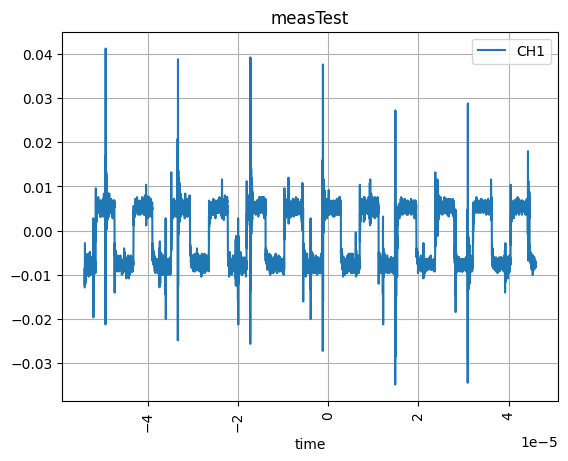

In [12]:
#read all chanels, parameters in one cmd 
title = "measTest"
df = get_signals(title)
dic= get_params_txt(title)
cols= list(df.columns)
cols.remove("time")
ax = df.plot(x="time", y=cols[0])  # First column on primary y-axis
for col in cols[1:]:
    df.plot(x="time", y=col, ax=ax, secondary_y=True)  # Rest on secondary y-axis
plt.grid()
plt.xticks(rotation=90)
plt.title(title)


plt.savefig(title+".png")
plt.show()

In [65]:
%%time 
time, voltage = get_data(chanel = "CH1")

CPU times: total: 0 ns
Wall time: 411 ms


In [66]:
%%time

# Save to .npy file
np.save("array.npy", voltage.astype("float32"))

# Load it back

# loaded_arr = np.load("array.npy")

CPU times: total: 0 ns
Wall time: 3.2 ms


In [67]:
def get_data_optim():
    global FIRST_TIME
    if FIRST_TIME: 
        FIRST_TIME= False 
        scope.write("DATA:SOURCE CH1")  
        # Set binary format  
        scope.write("DATA:ENC RIB") # Signed binary  
        scope.write("DATA:WIDTH 2") # 2 byte per point  
        # set your desired record length  
        scope.write("DATA:START 1")  
        scope.write("DATA:STOP 10000") 
    
    # Read waveform settings for scaling  
    x_increment = float(scope.query("WFMPRE:XINCR?"))  
    #x_origin = float(scope.query("WFMPRE:XZERO?"))  
    y_increment = float(scope.query("WFMPRE:YMULT?"))  
    y_origin = float(scope.query("WFMPRE:YZERO?"))  
    y_offset = float(scope.query("WFMPRE:YOFF?"))  
    
    
 
    
    # this issues the CURVE? query and returns a numpy int16 array  
    raw = scope.query_binary_values(  
    'CURVE?',  
    datatype='h', # 'h' = signed 16‑bit  
    is_big_endian=True, # or False depending on your scope  
    container=np.array  
    )  
    
    
    # Convert bytes to numpy array  
    wave = np.array( raw)  
    
    # Scale data  
    voltages = (wave - y_offset) * y_increment + y_origin  
    
    #times = np.arange(len(voltages)) * x_increment + x_origin 
    Ts= x_increment
    return Ts, voltages

In [82]:
def get_data_no_optim():

    FIRST_TIME= False 
    scope.write("DATA:SOURCE CH1")  
    # Set binary format  
    scope.write("DATA:ENC RIB") # Signed binary  
    scope.write("DATA:WIDTH 2") # 2 byte per point  
    # set your desired record length  
    scope.write("DATA:START 1")  
    scope.write("DATA:STOP 10000") 
    
    # Read waveform settings for scaling  
    x_increment = float(scope.query("WFMPRE:XINCR?"))  
    #x_origin = float(scope.query("WFMPRE:XZERO?"))  
    y_increment = float(scope.query("WFMPRE:YMULT?"))  
    y_origin = float(scope.query("WFMPRE:YZERO?"))  
    y_offset = float(scope.query("WFMPRE:YOFF?"))  
    
    
 
    
    # this issues the CURVE? query and returns a numpy int16 array  
    raw = scope.query_binary_values(  
    'CURVE?',  
    datatype='h', # 'h' = signed 16‑bit  
    is_big_endian=True, # or False depending on your scope  
    container=np.array  
    )  
    
    
    # Convert bytes to numpy array  
    wave = np.array( raw)  
    
    # Scale data  
    voltages = (wave - y_offset) * y_increment + y_origin  
    
    #times = np.arange(len(voltages)) * x_increment + x_origin 
    Ts= x_increment
    return Ts, voltages

In [85]:
%%time 
FIRST_TIME = True 
Ts, voltages = get_data_optim()

CPU times: total: 0 ns
Wall time: 382 ms


In [86]:
%%time 
Ts, voltages = get_data_optim()

CPU times: total: 0 ns
Wall time: 326 ms


In [87]:
%%time 
raw = scope.query_binary_values(  
'CURVE?',  
datatype='h', # 'h' = signed 16‑bit  
is_big_endian=True, # or False depending on your scope  
container=np.array  
)  

CPU times: total: 0 ns
Wall time: 322 ms


In [88]:
%%time 
Ts, voltages = get_data_no_optim()

CPU times: total: 0 ns
Wall time: 422 ms


In [93]:
def get_data_config():

    FIRST_TIME= False 
    scope.write("DATA:SOURCE CH1")  
    # Set binary format  
    scope.write("DATA:ENC RIB") # Signed binary  
    scope.write("DATA:WIDTH 2") # 2 byte per point  
    # set your desired record length  
    scope.write("DATA:START 1")  
    scope.write("DATA:STOP 10000") 
    
    # Read waveform settings for scaling  
    x_increment = float(scope.query("WFMPRE:XINCR?"))  
    #x_origin = float(scope.query("WFMPRE:XZERO?"))  
    y_increment = float(scope.query("WFMPRE:YMULT?"))  
    y_origin = float(scope.query("WFMPRE:YZERO?"))  
    y_offset = float(scope.query("WFMPRE:YOFF?"))  
    
    
    Ts= x_increment
    return Ts,  y_offset,  y_increment , y_origin  

In [94]:
# Only one time 

In [160]:
Ts,  y_offset,  y_increment , y_origin  = get_data_config()
Ts,  y_offset,  y_increment , y_origin 

(1e-08, 128.0, 1.5625e-06, 0.0)

In [96]:
def get_data_raw():

    # this issues the CURVE? query and returns a numpy int16 array  
    raw = scope.query_binary_values(  
    'CURVE?',  
    datatype='h', # 'h' = signed 16‑bit  
    is_big_endian=True, # or False depending on your scope  
    container=np.array  
    )  
    
    return raw 

In [108]:
%%time 
raw = get_data_raw()
raw = raw.astype("float32")
voltage = (raw - y_offset) * y_increment + y_origin  

CPU times: total: 0 ns
Wall time: 313 ms


## Sampling 10 samples

In [142]:
%%time 
N = 10
nbpoints = 10000
arr = np.zeros((N, nbpoints), dtype=np.float32)

for i in range(N):
    raw = get_data_raw().astype("float32")
    voltage = (raw - y_offset) * y_increment + y_origin
    arr[i] = voltage


CPU times: total: 31.2 ms
Wall time: 2.86 s


In [148]:
2.86*5000/3600,"h"

(3.9722222222222223, 'h')

In [147]:
arr=arr.flatten()

In [282]:
%%time

# Save to .npy file
np.save("array.npy", arr)
np.save("raw.npy", raw)

import json
data = {"Ts": Ts}
with open("Ts.json", "w") as f:
    json.dump(data, f)

    
# Load it back

# loaded_arr = np.load("array.npy")

CPU times: total: 0 ns
Wall time: 4.67 ms


In [162]:
with open("Ts.json", "r") as f:
    Ts = json.load(f)["Ts"]
Ts

1e-08

In [167]:
arr2= np.load("array.npy")

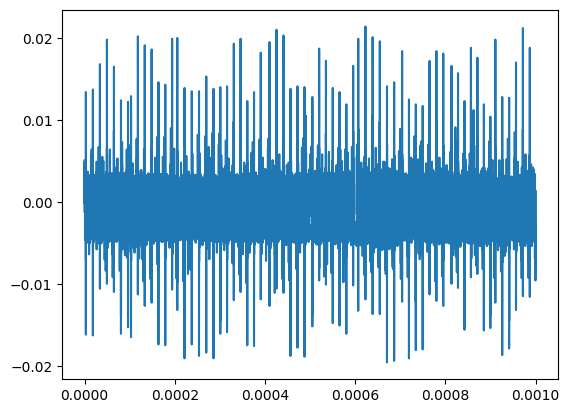

In [170]:
time = np.linspace (0,Ts*len(arr2), len(arr2))
plt.plot(time,arr2)

In [197]:
a = np.abs(arr2)
a.sort()
a= a[a!=0]
#pd.Series(np.diff(a)).value_counts()

verticalResolution = a[0]
print(verticalResolution, (verticalResolution*1e6).round(), "uV")

1e-04 100.0 uV


## FFT

In [207]:
import numpy as np
from scipy.fft import rfft, rfftfreq

def voltage_to_dBuV_spectrum(arr, Ts):
    """
    Compute the single-sided voltage spectrum of arr (in volts),
    and convert to dBµV (decibels relative to 1 µV).
    
    Returns:
        freqs: numpy array of frequency bins (Hz)
        spectrum_dBuV: numpy array of magnitudes in dBµV
    """
    N = len(arr)
    # FFT
    Y = rfft(arr)
    # Frequency bins
    freqs = rfftfreq(N, Ts)
    
    # Compute amplitude spectrum (peak)
    # Norm: divide by N so that the amplitude reflects actual signal amplitude
    # Because rfft gives only half spectrum, multiply non-DC components by 2
    # e.g. see many DSP references
    
    # Magnitude (absolute)
    mag = np.abs(Y) / N
    # multiply by 2 (for single-sided), except DC component at index 0
    mag[1:] = mag[1:] * 2

    # Convert volts → microvolts
    mag_uV = mag * 1e6  # now in µV

    # avoid log of zero
    #eps = 1e-20
    
    return freqs, mag_uV




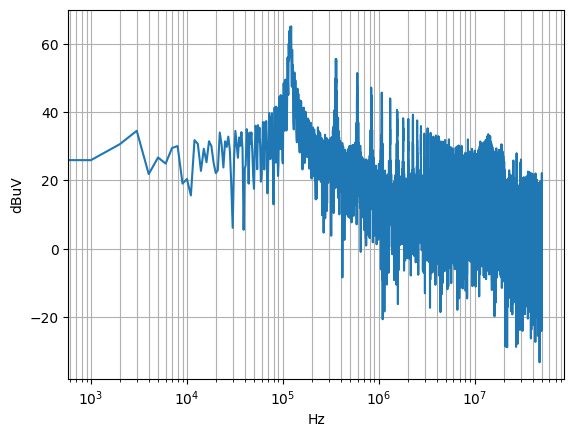

In [208]:
freqs, mag_uV= voltage_to_dBuV_spectrum(arr2, Ts)
# avoid log of zero
mask = mag_uV!=0
mag_uV=mag_uV[mask]
freqs=freqs[mask]
spectrum_dBuV = 20 * np.log10(mag_uV )

plt.plot(freqs, spectrum_dBuV )
plt.xscale("log")
plt.ylabel("dBuV")
plt.xlabel("Hz")
plt.grid(which="both")

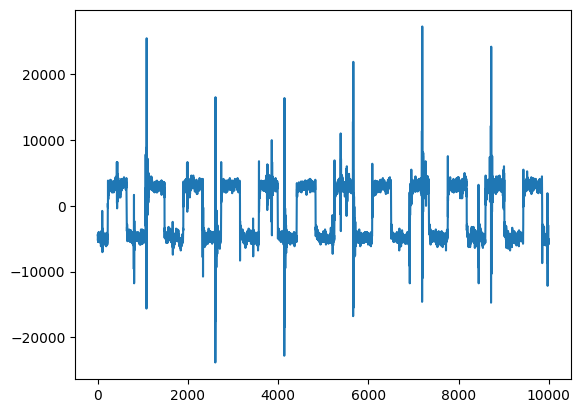

In [212]:
plt.plot(raw)

In [296]:
raw = np.load("raw.npy")

In [353]:
def finNbBits(raw):
    #nbBits = 
    for i in range(16,0,-1):
        y = raw/2**i
        if np.abs(y-y.round()).max()==0:
            return 16-i

nbbits = finNbBits(raw)
nbbits

9

In [354]:

# expect 10mV get '1.0E-2'
#resH= get_params_txt("")['CH1']['SCALE']
resH='1.0E-2'
resH

'1.0E-2'

In [355]:
div= 16-nbbits
y = raw/2**div
np.abs(y-y.round()).max()

np.float32(0.0)

In [356]:
int(1/float(resH))

100

In [357]:
y = y/(int(1/float(resH))*5) # 5 in positive 5 in negative

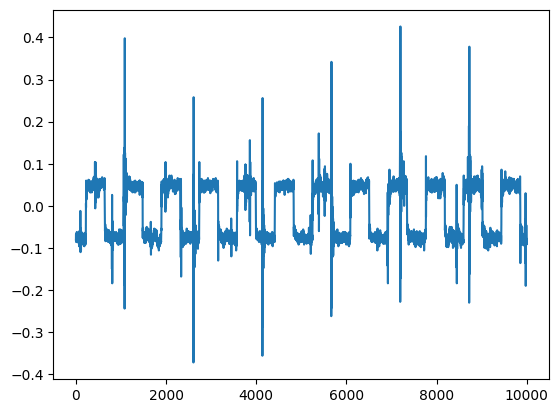

In [358]:
plt.plot(y)

In [363]:
spectrum_dBuV .max(), spectrum_dBuV .min()

(np.float32(97.88723), np.float32(9.147207))

In [364]:
a = np.abs(y)
a.sort()
a= a[a!=0]
#pd.Series(np.diff(a)).value_counts()

verticalResolution = a[0]
print(verticalResolution, (verticalResolution*1e6).round(), "uV")

0.002 2000.0 uV


In [365]:
from copy import copy 

In [366]:
a = copy(y)
a.sort()
pd.Series(np.diff(a)).value_counts().head()

0.000    9820
0.002      43
0.002      40
0.002      36
0.004       8
Name: count, dtype: int64

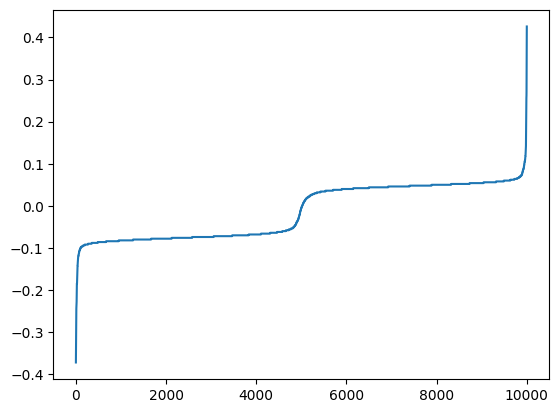

In [367]:
plt.plot(a)

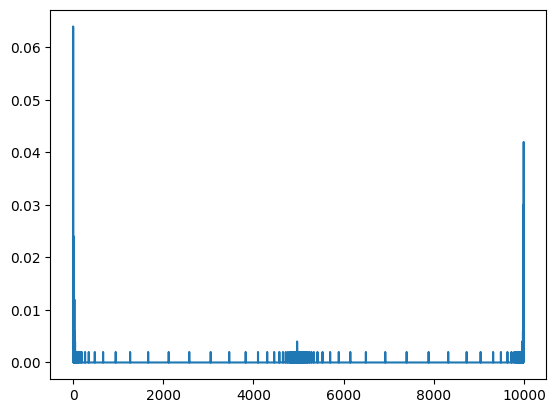

In [368]:
plt.plot(np.diff(a))

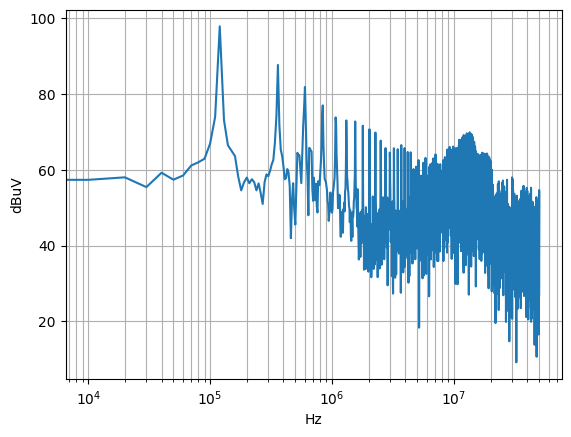

In [369]:
freqs, mag_uV= voltage_to_dBuV_spectrum(y, Ts)
# avoid log of zero
mask = mag_uV!=0
mag_uV=mag_uV[mask]
freqs=freqs[mask]
spectrum_dBuV = 20 * np.log10(mag_uV )

plt.plot(freqs, spectrum_dBuV )
plt.xscale("log")
plt.ylabel("dBuV")
plt.xlabel("Hz")
plt.grid(which="both")

In [370]:
import numpy as np
from scipy.fft import rfft, rfftfreq

def voltage_to_dBuV_spectrum2(arr, Ts):
    """
    Compute the single-sided voltage spectrum of arr (in volts),
    and convert to dBµV (decibels relative to 1 µV).
    
    Returns:
        freqs: numpy array of frequency bins (Hz)
        spectrum_dBuV: numpy array of magnitudes in dBµV
    """
    N = len(arr)
    # FFT
    Y = rfft(arr)
    # Frequency bins
    freqs = rfftfreq(N, Ts)
    
    # Compute amplitude spectrum (peak)
    # Norm: divide by N so that the amplitude reflects actual signal amplitude
    # Because rfft gives only half spectrum, multiply non-DC components by 2
    # e.g. see many DSP references
    
    # Magnitude (absolute)
    mag = np.abs(Y) *int(1e6/ N) # * 1e6  # now in µV
    # multiply by 2 (for single-sided), except DC component at index 0
    mag[1:] = mag[1:] * 2

    # Convert volts → microvolts
    mag_uV = mag 

    # avoid log of zero
    #eps = 1e-20
    
    return freqs, mag_uV




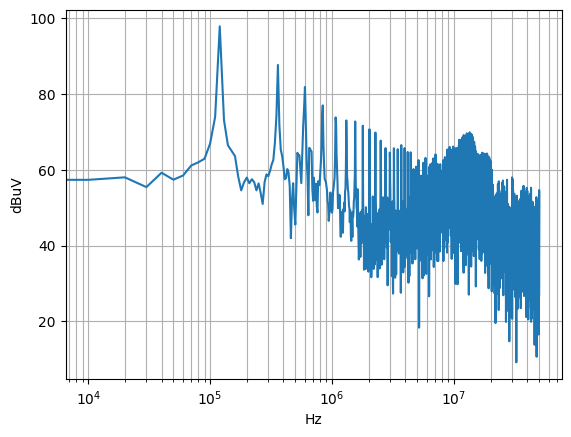

In [371]:
freqs, mag_uV= voltage_to_dBuV_spectrum2(y, Ts)
# avoid log of zero
mask = mag_uV!=0
mag_uV=mag_uV[mask]
freqs=freqs[mask]
spectrum_dBuV = 20 * np.log10(mag_uV )

plt.plot(freqs, spectrum_dBuV )
plt.xscale("log")
plt.ylabel("dBuV")
plt.xlabel("Hz")
plt.grid(which="both")

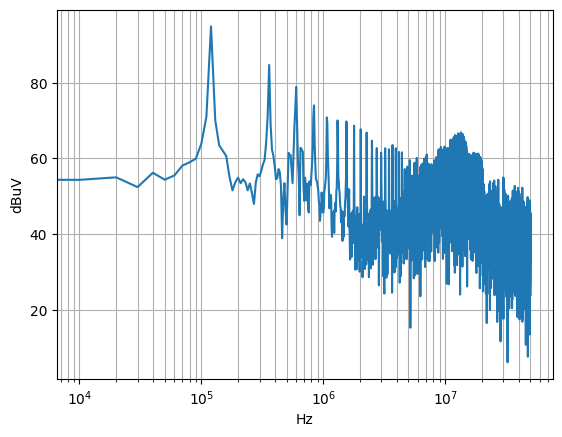

In [376]:
def spectrum_rms_dBuV(arr, Ts):
    N = len(arr)
    Y = rfft(arr)
    freqs = rfftfreq(N, Ts)
    mag = np.abs(Y) / N
    if N % 2 == 0:
        mag[1:-1] *= 2
    else:
        mag[1:] *= 2
    mag_rms = mag / np.sqrt(2)  # sine RMS
    spectrum_dBuV = 20*np.log10(np.maximum(mag_rms*1e6, 1e-15))
    return freqs, spectrum_dBuV
    
freqs, spectrum_dBuV= spectrum_rms_dBuV(y, Ts)



plt.plot(freqs, spectrum_dBuV )
plt.xscale("log")
plt.ylabel("dBuV")
plt.xlabel("Hz")
plt.grid(which="both")

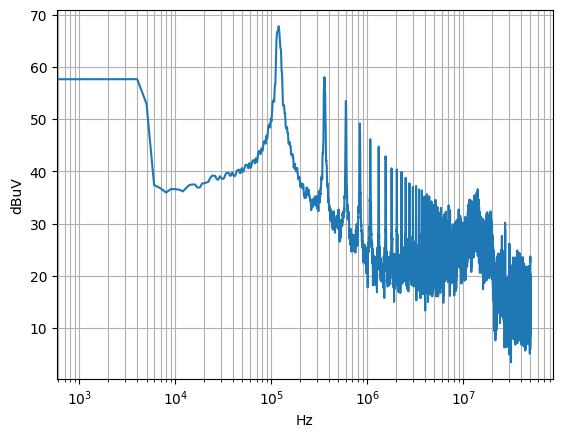

In [378]:
def spectrum_in_RBW_dBuV(arr, fs, rbw_hz, window='hann'):
    import numpy as np
    from scipy.fft import rfft, rfftfreq

    N = len(arr)
    Ts = 1.0/fs
    freqs = rfftfreq(N, Ts)

    # Window
    if window == 'hann':
        w = np.hanning(N)
    elif window == 'rect':
        w = np.ones(N)
    else:
        raise ValueError("window must be 'hann' or 'rect'")

    xw = arr * w

    # Periodogram normalization
    # U = mean(w^2) is the window power normalization
    U = np.mean(w**2)
    Xw = rfft(xw)

    # One-sided PSD [V^2/Hz]; bins 1..-2 doubled, DC/Nyquist not
    psd = (np.abs(Xw)**2) / (fs * N * U)
    if N % 2 == 0:
        psd[1:-1] *= 2
    else:
        psd[1:] *= 2

    # Integrate PSD over RBW to get Vrms in that RBW
    # Approximate by multiplying per-bin PSD by equivalent noise bandwidth (ENBW)
    # A common, simple approximation: Vrms_per_bin ≈ sqrt(PSD * Δf)
    # To emulate an RBW, smooth (convolve) PSD with a rectangular kernel spanning rbw_hz.
    delta_f = fs / N
    bins_in_rbw = max(1, int(np.round(rbw_hz / delta_f)))

    # Moving-average of PSD over RBW
    kernel = np.ones(bins_in_rbw) / bins_in_rbw
    psd_rbw = np.convolve(psd, kernel, mode='same')  # still V^2/Hz

    # Voltage RMS in RBW: sqrt(PSD * RBW)
    Vrms_in_rbw = np.sqrt(psd_rbw * rbw_hz)

    dBuV = 20*np.log10(np.maximum(Vrms_in_rbw * 1e6, 1e-15))
    return freqs, dBuV


freqs, spectrum_dBuV = spectrum_in_RBW_dBuV(arr=arr2, fs=1/Ts, rbw_hz=9e3, window='hann')



plt.plot(freqs, spectrum_dBuV )
plt.xscale("log")
plt.ylabel("dBuV")
plt.xlabel("Hz")
plt.grid(which="both")

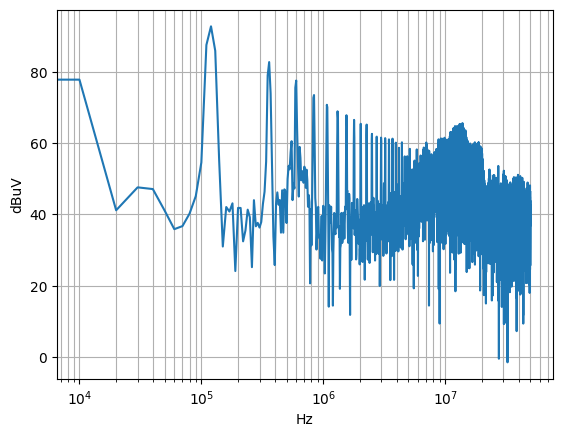

In [383]:
freqs, spectrum_dBuV = spectrum_in_RBW_dBuV(arr=y, fs=1/Ts, rbw_hz=9e3, window='hann')



plt.plot(freqs, spectrum_dBuV )#, marker= "x")
plt.xscale("log")
plt.ylabel("dBuV")
plt.xlabel("Hz")
plt.grid(which="both")

In [384]:
freqs

array([0.000e+00, 1.000e+04, 2.000e+04, ..., 4.998e+07, 4.999e+07,
       5.000e+07], shape=(5001,))

# emi reciever emulation 1

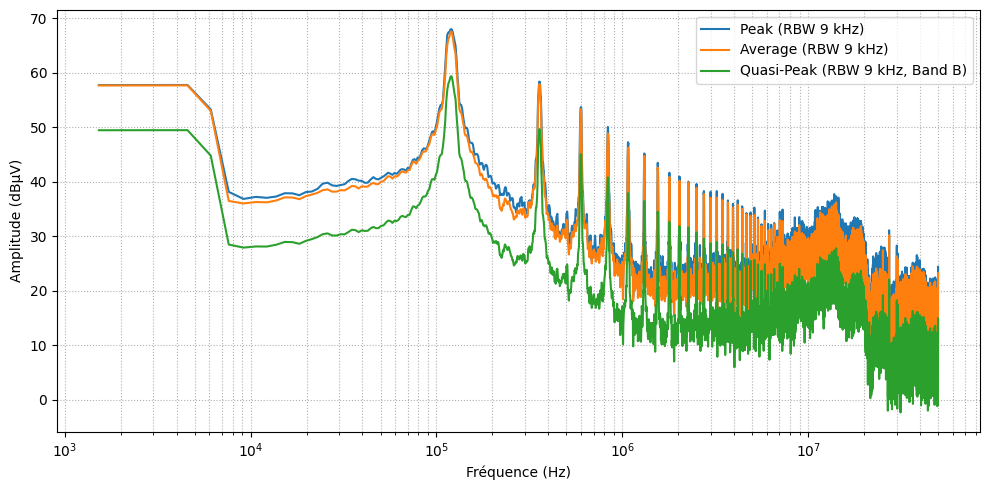

In [393]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq

# ---------- Helpers ----------

def _next_pow2(n):
    return 1 << (int(n - 1).bit_length())

def _choose_nfft(fs, rbw_hz, oversample=5, max_nfft=1<<18):
    """
    Pick NFFT so that Δf = fs/NFFT <= RBW/oversample, limited to max_nfft.
    """
    target_df = rbw_hz / float(oversample)
    nfft = int(np.ceil(fs / target_df))
    nfft = _next_pow2(max(1024, nfft))
    return min(nfft, max_nfft)

def _one_sided_psd(frame, fs, window):
    """
    Periodogram with window power normalization, one-sided doubling.
    PSD units: V^2/Hz. Shape: (N/2+1,)
    """
    N = len(frame)
    U = np.mean(window**2)  # window power
    X = rfft(frame * window)
    psd = (np.abs(X)**2) / (fs * N * U)  # two-sided to start
    # One-sided doubling (except DC and Nyquist for even N)
    if N % 2 == 0:
        psd[1:-1] *= 2.0
    else:
        psd[1:] *= 2.0
    return psd

def _quasi_peak(envelope, dt, tau_c, tau_d, return_mode="max"):
    """
    Quasi-peak detector on a non-negative envelope (e.g., Vrms in RBW per frame).
    Attack (charge) with tau_c, decay (discharge) with tau_d.
    Return either the max detector output over time or the final value.
    """
    y = 0.0
    out = np.empty_like(envelope)
    a_c = np.exp(-dt / tau_c)
    a_d = np.exp(-dt / tau_d)
    for i, x in enumerate(envelope):
        if x >= y:
            y = a_c * y + (1 - a_c) * x
        else:
            y = a_d * y + (1 - a_d) * x
        out[i] = y
    return out.max() if return_mode == "max" else out[-1]

# ---------- Main function ----------

def emi_detectors_rbw(arr, Ts, rbw_hz=9e3, window_name='hann',
                      nfft=None, overlap=0.75,
                      qp_band='B', qp_return='max'):
    """
    Compute Peak / Average / Quasi-Peak in dBµV for RBW integration.

    Parameters
    ----------
    arr : 1D np.ndarray
        Time-domain signal in Volts.
    Ts : float
        Sampling period in seconds.
    rbw_hz : float
        Resolution bandwidth (Hz). Default 9 kHz.
    window_name : {'hann','rect'}
        STFT analysis window.
    nfft : int or None
        FFT size per frame. If None, chosen automatically vs RBW.
    overlap : float in [0,1)
        Frame overlap fraction.
    qp_band : {'A','B','C','D'}
        Select CISPR band for time constants:
        - A: 9–150 kHz → RBW 200 Hz (not used here), τc=45 ms, τd=500 ms
        - B: 150 kHz–30 MHz → RBW 9 kHz, τc=1 ms, τd=160 ms (default)
        - C/D: ≥30 MHz → RBW 120 kHz, τc=1 ms, τd=550 ms
    qp_return : {'max','final'}
        Whether to return max or final quasi-peak output along time.

    Returns
    -------
    freqs : 1D array (Hz)
    dBuV_peak : 1D array
    dBuV_avg  : 1D array
    dBuV_qp   : 1D array
    """

    fs = 1.0 / Ts
    x = np.asarray(arr, dtype=float)
    Nsig = len(x)

    # Window
    if window_name == 'hann':
        win_fn = np.hanning
    elif window_name == 'rect':
        win_fn = np.ones
    else:
        raise ValueError("window_name must be 'hann' or 'rect'")

    # Pick NFFT if not provided
    if nfft is None:
        nfft = _choose_nfft(fs, rbw_hz, oversample=5)
    nfft = min(nfft, Nsig) if Nsig < nfft else nfft

    hop = max(1, int(nfft * (1.0 - overlap)))
    window = win_fn(nfft)

    # Frame indices
    starts = np.arange(0, Nsig - nfft + 1, hop, dtype=int)
    if len(starts) == 0:
        # zero-pad one frame
        pad = np.zeros(nfft, dtype=float)
        pad[:Nsig] = x
        frames = pad[None, :]
        starts = np.array([0])
    else:
        frames = np.lib.stride_tricks.as_strided(
            x, shape=(len(starts), nfft),
            strides=(x.strides[0]*hop, x.strides[0])
        ).copy()

    # PSD per frame (one-sided)
    psd_list = []
    for fr in frames:
        psd_list.append(_one_sided_psd(fr, fs, window))
    psd = np.vstack(psd_list)    # shape: (T, F)
    freqs = rfftfreq(nfft, Ts)
    df = fs / nfft

    # RBW integration via rectangular kernel ~ sum over bins_in_rbw
    bins_in_rbw = max(1, int(round(rbw_hz / df)))
    ker = np.ones(bins_in_rbw, dtype=float)

    # For each time frame: sum PSD over RBW, then multiply by Δf to get V^2
    from numpy import convolve
    P_rbw = np.empty_like(psd)
    for t in range(psd.shape[0]):
        # 'same' keeps length; at edges the effective BW is smaller (ok for display)
        psd_sum = np.convolve(psd[t], ker, mode='same')
        P_rbw[t] = psd_sum * df  # Power (V^2) integrated over ~RBW

    # Voltage RMS per time & frequency
    Vrms = np.sqrt(np.maximum(P_rbw, 0.0))  # shape (T, F)

    # Detectors along time
    # Peak: max over time
    Vrms_peak = Vrms.max(axis=0)

    # Average: linear average over time (CISPR "average")
    Vrms_avg = Vrms.mean(axis=0)

    # Quasi-Peak constants per CISPR band
    if qp_band.upper() == 'A':
        tau_c, tau_d = 45e-3, 500e-3   # 9–150 kHz (RBW 200 Hz, informative)
    elif qp_band.upper() == 'B':
        tau_c, tau_d = 1e-3, 160e-3    # 150 kHz–30 MHz, RBW 9 kHz
    elif qp_band.upper() in ('C','D'):
        tau_c, tau_d = 1e-3, 550e-3    # 30–1000 MHz, RBW 120 kHz
    else:
        raise ValueError("qp_band must be one of {'A','B','C','D'}")

    dt = hop / fs  # detector time step equals frame hop duration
    Vrms_qp = np.empty(Vrms.shape[1], dtype=float)
    for f_idx in range(Vrms.shape[1]):
        Vrms_qp[f_idx] = _quasi_peak(Vrms[:, f_idx], dt, tau_c, tau_d, return_mode=qp_return)

    # Convert to dBµV
    eps = 1e-15  # numerical floor to prevent log(0)
    dBuV_peak = 20.0 * np.log10(np.maximum(Vrms_peak, eps) * 1e6)
    dBuV_avg  = 20.0 * np.log10(np.maximum(Vrms_avg,  eps) * 1e6)
    dBuV_qp   = 20.0 * np.log10(np.maximum(Vrms_qp,   eps) * 1e6)

    return freqs, dBuV_peak, dBuV_avg, dBuV_qp

# ---------- Example usage (with your arr2, Ts) ----------
freqs, dBuV_peak, dBuV_avg, dBuV_qp = emi_detectors_rbw(arr2, Ts, rbw_hz=9e3, window_name='hann', overlap=0.75)

plt.figure(figsize=(10,5))
plt.semilogx(freqs[1:], dBuV_peak[1:], label='Peak (RBW 9 kHz)')
plt.semilogx(freqs[1:], dBuV_avg[1:],  label='Average (RBW 9 kHz)')
plt.semilogx(freqs[1:], dBuV_qp[1:],   label='Quasi-Peak (RBW 9 kHz, Band B)')
plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()


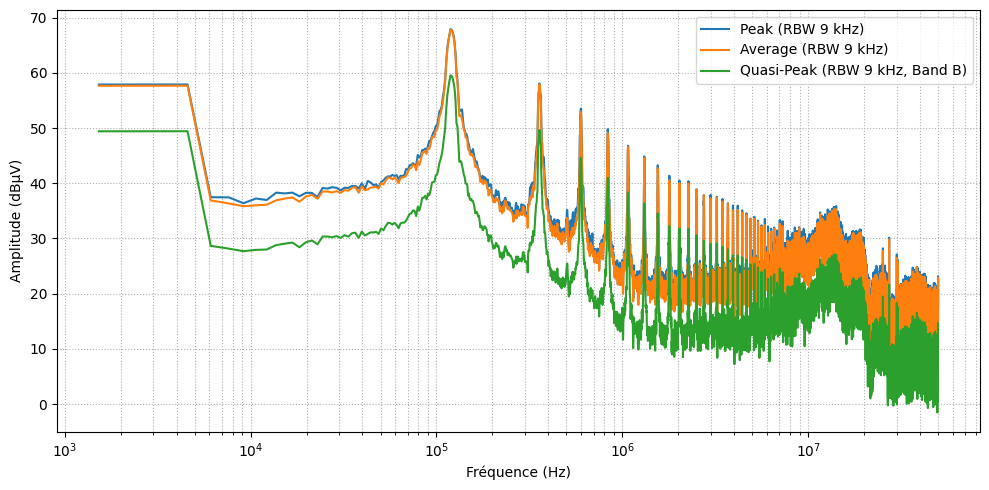

In [394]:
# ---------- Example usage (with your arr2, Ts) ----------
freqs, dBuV_peak, dBuV_avg, dBuV_qp = emi_detectors_rbw(arr2, Ts, rbw_hz=9e3, window_name='rect', overlap=0.75)

plt.figure(figsize=(10,5))
plt.semilogx(freqs[1:], dBuV_peak[1:], label='Peak (RBW 9 kHz)')
plt.semilogx(freqs[1:], dBuV_avg[1:],  label='Average (RBW 9 kHz)')
plt.semilogx(freqs[1:], dBuV_qp[1:],   label='Quasi-Peak (RBW 9 kHz, Band B)')
plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()

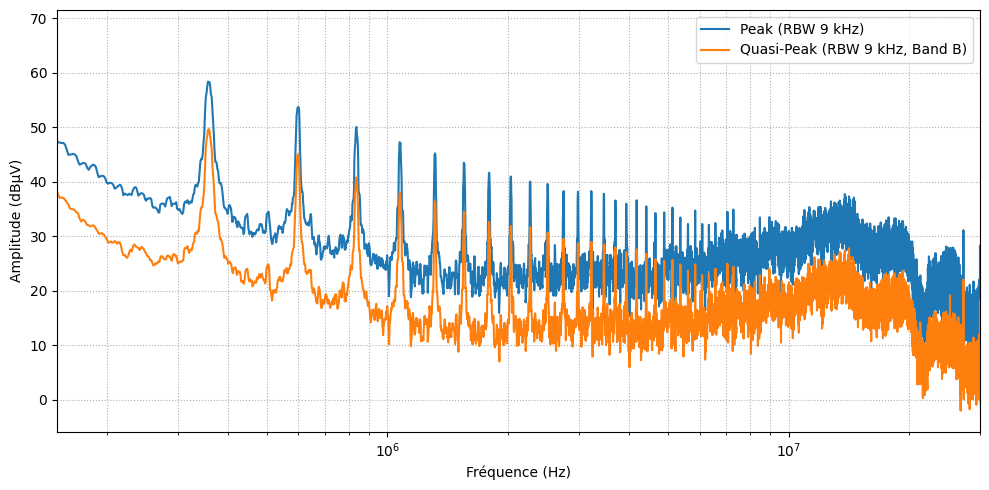

In [395]:
# ---------- Example usage (with your arr2, Ts) ----------
freqs, dBuV_peak, dBuV_avg, dBuV_qp = emi_detectors_rbw(arr2, Ts, rbw_hz=9e3, window_name='hann', overlap=0.75)

plt.figure(figsize=(10,5))
plt.semilogx(freqs[1:], dBuV_peak[1:], label='Peak (RBW 9 kHz)')
#plt.semilogx(freqs[1:], dBuV_avg[1:],  label='Average (RBW 9 kHz)')
plt.semilogx(freqs[1:], dBuV_qp[1:],   label='Quasi-Peak (RBW 9 kHz, Band B)')
plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (Hz)')
plt.xlim (   [150e3,30e6])
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()

# Gaussian 9 kHz RBW instead of boxcar

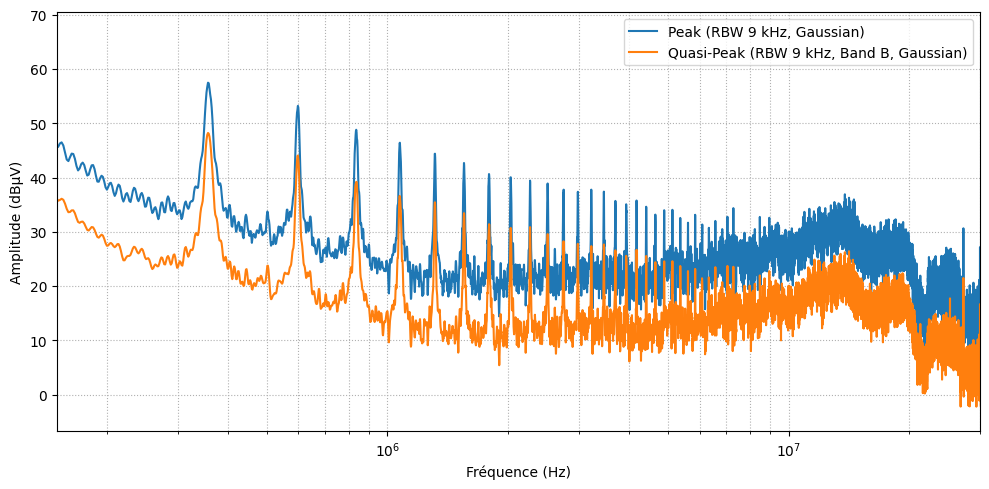

In [396]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
# ---------- Helpers ----------

def _next_pow2(n):
    # next power of two >= n
    return 1 << (int(n - 1).bit_length())

def _choose_nfft(fs, rbw_hz, oversample=5, max_nfft=1 << 18):
    """
    Pick NFFT so that Δf = fs/NFFT <= RBW/oversample, limited to max_nfft.
    """
    target_df = rbw_hz / float(oversample)
    nfft = int(np.ceil(fs / target_df))
    nfft = _next_pow2(max(1024, nfft))
    return min(nfft, max_nfft)

def _one_sided_psd(frame, fs, window):
    """
    Periodogram with window power normalization, one-sided doubling.
    PSD units: V^2/Hz. Shape: (N/2+1,)
    """
    N = len(frame)
    U = np.mean(window**2)  # window power
    X = rfft(frame * window)
    psd = (np.abs(X)**2) / (fs * N * U)  # two-sided to start
    # One-sided doubling (except DC and Nyquist for even N)
    if N % 2 == 0:
        psd[1:-1] *= 2.0
    else:
        psd[1:] *= 2.0
    return psd
def _quasi_peak(envelope, dt, tau_c, tau_d, return_mode="max"):
    """
    Quasi-peak detector on a non-negative envelope (e.g., Vrms in RBW per frame).
    Attack (charge) with tau_c, decay (discharge) with tau_d.
    Return either the max detector output over time or the final value.
    """
    y = 0.0
    out = np.empty_like(envelope)
    a_c = np.exp(-dt / tau_c)
    a_d = np.exp(-dt / tau_d)
    for i, x in enumerate(envelope):
        if x >= y:
            y = a_c * y + (1 - a_c) * x
        else:
            y = a_d * y + (1 - a_d) * x
        out[i] = y
    return out.max() if return_mode == "max" else out[-1]

def _gaussian_rbw_kernel(df, rbw_hz, span_sigmas=5):
    """
    Build |H(f)|^2 kernel approximating CISPR quasi-Gaussian RBW.

    We choose a Gaussian AMPLITUDE response H(f) with –6 dB amplitude at ±RBW/2.
    For Gaussian amplitude: H(f) = exp(-(f^2)/(2σ^2)).
      –6 dB amplitude point: |H(f6)| = 10^(-6/20) ≈ 0.501187.
      => f6 = σ * sqrt(2 ln(1/0.501187)) ≈ 1.176 σ  ⇒ σ ≈ (RBW/2)/1.176.
    We convolve PSD with |H|^2, then multiply by Δf to approximate ∫ PSD·|H|^2 df.
    """
    f6 = rbw_hz / 2.0
    sigma = f6 / 1.176  # ≈ RBW / 2.352

    # Discretize kernel over ±span_sigmas·σ
    half_span_hz = span_sigmas * sigma
    half_bins = int(np.ceil(half_span_hz / df))
    offs = (np.arange(-half_bins, half_bins + 1) * df)
    H_amp = np.exp(-0.5 * (offs / sigma) ** 2)   # amplitude response
    kernel_power = H_amp ** 2                    # |H|^2 for power integration
    return kernel_power

# ---------- Main function ----------
def emi_detectors_rbw2(arr, Ts, rbw_hz=9e3, window_name='hann',
                      nfft=None, overlap=0.75,
                      qp_band='B', qp_return='max',
                      rbw_shape='gaussian', span_sigmas=5):
    """
    Compute Peak / Average / Quasi-Peak in dBµV for RBW integration.

    Parameters
    ----------
    arr : 1D np.ndarray
        Time-domain signal in Volts.
    Ts : float
        Sampling period in seconds.
    rbw_hz : float
        Resolution bandwidth (Hz). Default 9 kHz.
    window_name : {'hann','rect'}
        STFT analysis window (leakage control; not the IF filter).
    nfft : int or None
        FFT size per frame. If None, chosen automatically vs RBW.
    overlap : float in [0,1)
        Frame overlap fraction.
    qp_band : {'A','B','C','D'}
        CISPR band for QP time constants:
        - A: 9–150 kHz → RBW 200 Hz, τc=45 ms, τd=500 ms
        - B: 150 kHz–30 MHz → RBW 9 kHz, τc=1 ms, τd=160 ms (default)
        - C/D: ≥30 MHz → RBW 120 kHz, τc=1 ms, τd=550 ms
    qp_return : {'max','final'}
        Return max or final quasi-peak output along time.
    rbw_shape : {'gaussian','rect'}
        RBW integration kernel in frequency. 'gaussian' approximates CISPR IF.
    span_sigmas : int
        Width of Gaussian kernel in ±σ units (only used for 'gaussian').

    Returns
    -------
    freqs : 1D array (Hz)
    dBuV_peak : 1D array
    dBuV_avg  : 1D array
    dBuV_qp   : 1D array
    """

    fs = 1.0 / Ts
    x = np.asarray(arr, dtype=float)
    Nsig = len(x)

    # Analysis window (for PSD leakage control)
    if window_name == 'hann':
        win_fn = np.hanning
    elif window_name == 'rect':
        win_fn = np.ones
    else:
        raise ValueError("window_name must be 'hann' or 'rect'")

    # Pick NFFT if not provided
    if nfft is None:
        nfft = _choose_nfft(fs, rbw_hz, oversample=5)
    nfft = min(nfft, Nsig) if Nsig < nfft else nfft

    hop = max(1, int(nfft * (1.0 - overlap)))
    window = win_fn(nfft)

    # Frame indices
    starts = np.arange(0, Nsig - nfft + 1, hop, dtype=int)
    if len(starts) == 0:
        # zero-pad one frame
        pad = np.zeros(nfft, dtype=float)
        pad[:Nsig] = x
        frames = pad[None, :]
        starts = np.array([0])
    else:
        frames = np.lib.stride_tricks.as_strided(
            x, shape=(len(starts), nfft),
            strides=(x.strides[0]*hop, x.strides[0])
        ).copy()

    # PSD per frame (one-sided)
    psd_list = []
    for fr in frames:
        psd_list.append(_one_sided_psd(fr, fs, window))
    psd = np.vstack(psd_list)    # shape: (T, F)
    freqs = rfftfreq(nfft, Ts)
    df = fs / nfft

    # ----- RBW integration via kernel in frequency -----
    if rbw_shape == 'gaussian':
        ker = _gaussian_rbw_kernel(df, rbw_hz, span_sigmas=span_sigmas)
    elif rbw_shape == 'rect':
        bins_in_rbw = max(1, int(round(rbw_hz / df)))
        ker = np.ones(bins_in_rbw, dtype=float)
    else:
        raise ValueError("rbw_shape must be 'gaussian' or 'rect'")

    from numpy import convolve
    P_rbw = np.empty_like(psd)
    for t in range(psd.shape[0]):
        if rbw_shape == 'rect':
            psd_sum = np.convolve(psd[t], ker, mode='same')
            P_rbw[t] = psd_sum * df               # rectangular: sum * Δf
        else:
            # Gaussian: integrate PSD * |H|^2 over frequency
            psd_w = np.convolve(psd[t], ker, mode='same')
            P_rbw[t] = psd_w * df                 # ∑ PSD·|H|^2 · Δf ≈ ∫ PSD·|H|^2 df

    # Voltage RMS per time & frequency
    Vrms = np.sqrt(np.maximum(P_rbw, 0.0))  # shape (T, F)

    # Detectors along time
    Vrms_peak = Vrms.max(axis=0)    # Peak
    Vrms_avg  = Vrms.mean(axis=0)   # Average (linear)

    # Quasi-Peak constants per CISPR band
    if qp_band.upper() == 'A':
        tau_c, tau_d = 45e-3, 500e-3
    elif qp_band.upper() == 'B':
        tau_c, tau_d = 1e-3, 160e-3
    elif qp_band.upper() in ('C', 'D'):
        tau_c, tau_d = 1e-3, 550e-3
    else:
        raise ValueError("qp_band must be one of {'A','B','C','D'}")

    dt = hop / fs  # detector time step equals frame hop duration
    Vrms_qp = np.empty(Vrms.shape[1], dtype=float)
    for f_idx in range(Vrms.shape[1]):
        Vrms_qp[f_idx] = _quasi_peak(Vrms[:, f_idx], dt, tau_c, tau_d, return_mode=qp_return)

    # Convert to dBµV
    eps = 1e-15  # numerical floor to prevent log(0)
    dBuV_peak = 20.0 * np.log10(np.maximum(Vrms_peak, eps) * 1e6)
    dBuV_avg  = 20.0 * np.log10(np.maximum(Vrms_avg,  eps) * 1e6)
    dBuV_qp   = 20.0 * np.log10(np.maximum(Vrms_qp,   eps) * 1e6)

    return freqs, dBuV_peak, dBuV_avg, dBuV_qp

# ---------- Example usage (with your arr2, Ts) ----------
# Choose Gaussian RBW (default)
freqs, dBuV_peak, dBuV_avg, dBuV_qp = emi_detectors_rbw2(
    arr2, Ts, rbw_hz=9e3, window_name='hann', overlap=0.75,
    rbw_shape='gaussian', span_sigmas=5, qp_band='B'
)

plt.figure(figsize=(10,5))
plt.semilogx(freqs[1:], dBuV_peak[1:], label='Peak (RBW 9 kHz, Gaussian)')
# plt.semilogx(freqs[1:], dBuV_avg[1:],  label='Average (RBW 9 kHz, Gaussian)')
plt.semilogx(freqs[1:], dBuV_qp[1:],   label='Quasi-Peak (RBW 9 kHz, Band B, Gaussian)')
plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (Hz)')
plt.xlim([150e3, 30e6])
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()


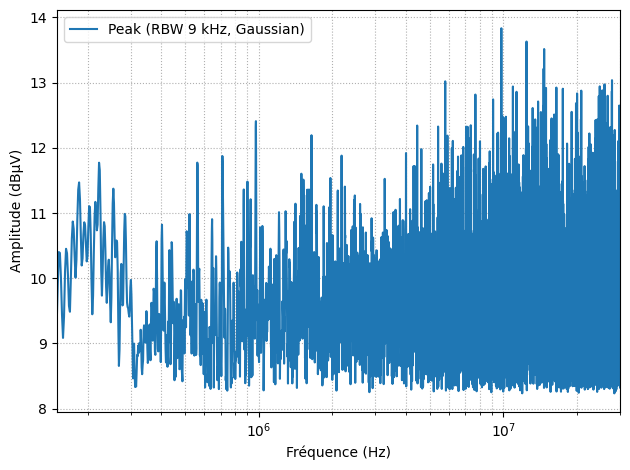

In [403]:
plt.semilogx(freqs[1:], dBuV_peak[1:]-dBuV_qp[1:], label='Peak (RBW 9 kHz, Gaussian)')
plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (Hz)')
plt.xlim([150e3, 30e6])
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()

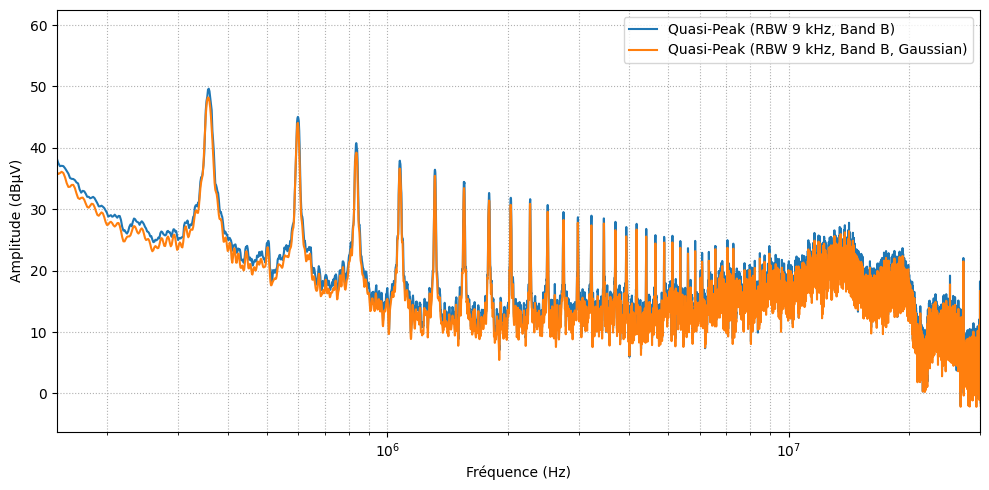

In [400]:
# ---------- Example usage (with your arr2, Ts) ----------
freqs, dBuV_peak, dBuV_avg, dBuV_qp = emi_detectors_rbw(arr2, Ts, rbw_hz=9e3, window_name='hann', overlap=0.75)

plt.figure(figsize=(10,5))
#plt.semilogx(freqs[1:], dBuV_peak[1:], label='Peak (RBW 9 kHz)')
#plt.semilogx(freqs[1:], dBuV_avg[1:],  label='Average (RBW 9 kHz)')
plt.semilogx(freqs[1:], dBuV_qp[1:],   label='Quasi-Peak (RBW 9 kHz, Band B)')
#plt.semilogx(freqs[1:], dBuV_qp[1:],   label='Quasi-Peak (RBW 9 kHz, Band B, Gaussian)')



freqs, dBuV_peak, dBuV_avg, dBuV_qp = emi_detectors_rbw2(
    arr2, Ts, rbw_hz=9e3, window_name='hann', overlap=0.75,
    rbw_shape='gaussian', span_sigmas=5, qp_band='B'
)


plt.semilogx(freqs[1:], dBuV_qp[1:],   label='Quasi-Peak (RBW 9 kHz, Band B, Gaussian)')



plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (Hz)')
plt.xlim (   [150e3,30e6])
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()

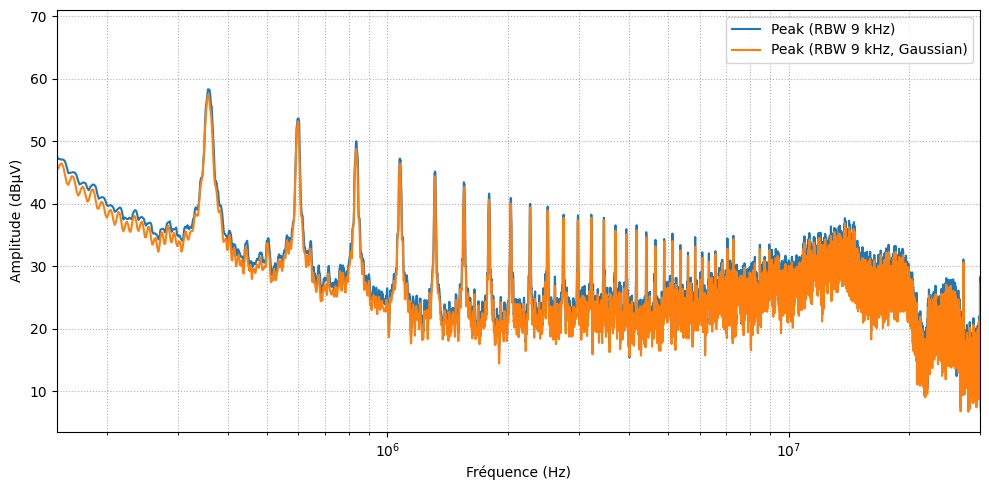

In [401]:
# ---------- Example usage (with your arr2, Ts) ----------
freqs, dBuV_peak, dBuV_avg, dBuV_qp = emi_detectors_rbw(arr2, Ts, rbw_hz=9e3, window_name='hann', overlap=0.75)

plt.figure(figsize=(10,5))
plt.semilogx(freqs[1:], dBuV_peak[1:], label='Peak (RBW 9 kHz)')
#plt.semilogx(freqs[1:], dBuV_avg[1:],  label='Average (RBW 9 kHz)')
#plt.semilogx(freqs[1:], dBuV_qp[1:],   label='Quasi-Peak (RBW 9 kHz, Band B)')
#plt.semilogx(freqs[1:], dBuV_qp[1:],   label='Quasi-Peak (RBW 9 kHz, Band B, Gaussian)')



freqs, dBuV_peak, dBuV_avg, dBuV_qp = emi_detectors_rbw2(
    arr2, Ts, rbw_hz=9e3, window_name='hann', overlap=0.75,
    rbw_shape='gaussian', span_sigmas=5, qp_band='B'
)


#plt.semilogx(freqs[1:], dBuV_qp[1:],   label='Quasi-Peak (RBW 9 kHz, Band B, Gaussian)')

plt.semilogx(freqs[1:], dBuV_peak[1:], label='Peak (RBW 9 kHz, Gaussian)')

plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (Hz)')
plt.xlim (   [150e3,30e6])
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()

## Smapling 100 samples

In [416]:
Ts,  y_offset,  y_increment , y_origin  = get_data_config()
Ts,  y_offset,  y_increment , y_origin 

(1e-08, 128.0, 1.5625e-06, 0.0)

In [417]:
%%time 
N = 100
nbpoints = 10000
arr = np.zeros((N, nbpoints), dtype=np.float32)

for i in range(N):
    raw = get_data_raw().astype("float32")
    voltage = (raw - y_offset) * y_increment + y_origin
    arr[i] = voltage


CPU times: total: 78.1 ms
Wall time: 31.2 s


In [426]:
(31.2/100)*5000/60,"min"

(26.0, 'min')

In [418]:
arr=arr.flatten()

In [419]:
%%time

# Save to .npy file
np.save("array2.npy", arr)
np.save("raw2.npy", raw)

import json
data = {"Ts": Ts}
with open("Ts2.json", "w") as f:
    json.dump(data, f)

    
# Load it back

# loaded_arr = np.load("array.npy")

CPU times: total: 0 ns
Wall time: 11.1 ms


In [420]:
with open("Ts2.json", "r") as f:
    Ts = json.load(f)["Ts"]
Ts

1e-08

In [424]:
len(arr2)/1e4

100.0

In [421]:
arr2= np.load("array2.npy")

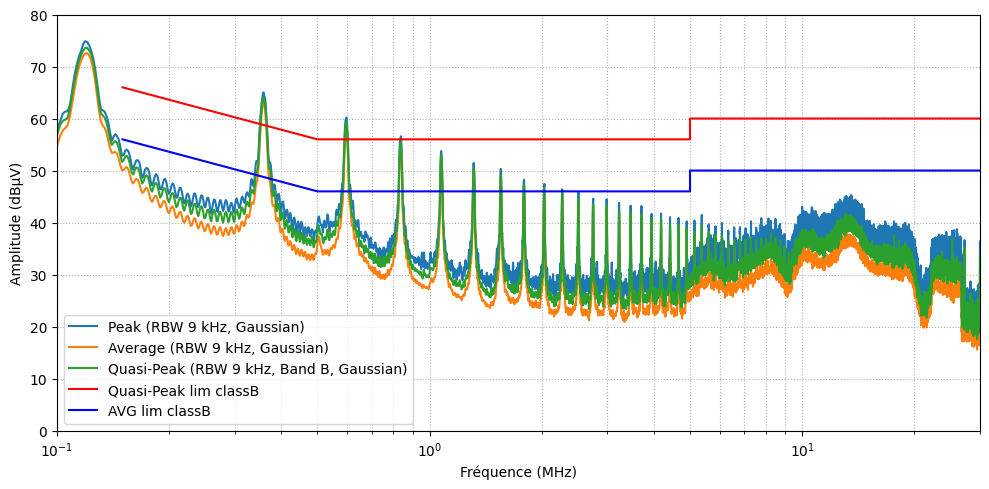

In [448]:
freqs, dBuV_peak, dBuV_avg, dBuV_qp = emi_detectors_rbw2(
    arr2, Ts, rbw_hz=9e3, window_name='hann', overlap=0.75,
    rbw_shape='gaussian', span_sigmas=5, qp_band='B'
)


plt.figure(figsize=(10,5))
plt.semilogx(freqs[1:]*1e-6, dBuV_peak[1:], label='Peak (RBW 9 kHz, Gaussian)')
plt.semilogx(freqs[1:]*1e-6, dBuV_avg[1:],  label='Average (RBW 9 kHz, Gaussian)')
plt.semilogx(freqs[1:]*1e-6, dBuV_qp[1:],   label='Quasi-Peak (RBW 9 kHz, Band B, Gaussian)')

# see https://www.ti.com/document-viewer/lit/html/SSZT673
_= """
150 kHz → 530 kHz: 66 dBµV → 56 dBµV (logarithmic slope)
530 kHz → 5 MHz: 56 dBµV (flat)
5 MHz → 30 MHz: 60 dBµV  (flat)
""" # for peak and qpeak is the same , limite are the same for CISPR-16 and 25
# Class A: Limits for industrial/commercial environments → less strict (higher allowed emissions).
# Class B: Limits for residential environments → more strict (lower allowed emissions).
freqs0 = np.array([150e3, 500e3, 5e6, 5e6,30e6])
qp_limits = np.array([66, 56, 56, 60, 60])   # dBµV
avg_limits = np.array([56, 46, 46, 50,50])  # dBµV
plt.semilogx(freqs0*1e-6, qp_limits ,   label='Quasi-Peak lim classB', c="r")
plt.semilogx(freqs0*1e-6,avg_limits  ,   label='AVG lim classB', c= "b")
plt.ylim([0,80])
plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (MHz)')
plt.xlim([0.1, 30])
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()

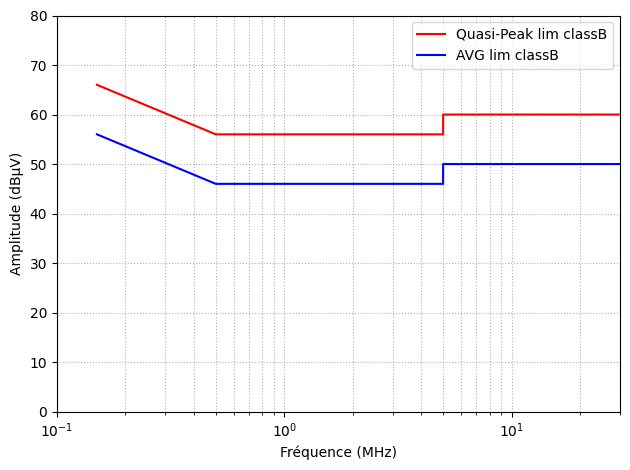

In [447]:
# see https://www.ti.com/document-viewer/lit/html/SSZT673
_= """
150 kHz → 530 kHz: 66 dBµV → 56 dBµV (logarithmic slope)
530 kHz → 5 MHz: 56 dBµV (flat)
5 MHz → 30 MHz: 60 dBµV  (flat)
""" # for peak and qpeak is the same , limite are the same for CISPR-16 and 25
# Class A: Limits for industrial/commercial environments → less strict (higher allowed emissions).
# Class B: Limits for residential environments → more strict (lower allowed emissions).
freqs = np.array([150e3, 500e3, 5e6, 5e6,30e6])
qp_limits = np.array([66, 56, 56, 60, 60])   # dBµV
avg_limits = np.array([56, 46, 46, 50,50])  # dBµV
plt.semilogx(freqs*1e-6, qp_limits ,   label='Quasi-Peak lim classB', c="r")
plt.semilogx(freqs*1e-6,avg_limits  ,   label='AVG lim classB', c= "b")
plt.ylim([0,80])
plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (MHz)')
plt.xlim([0.1, 30])
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()

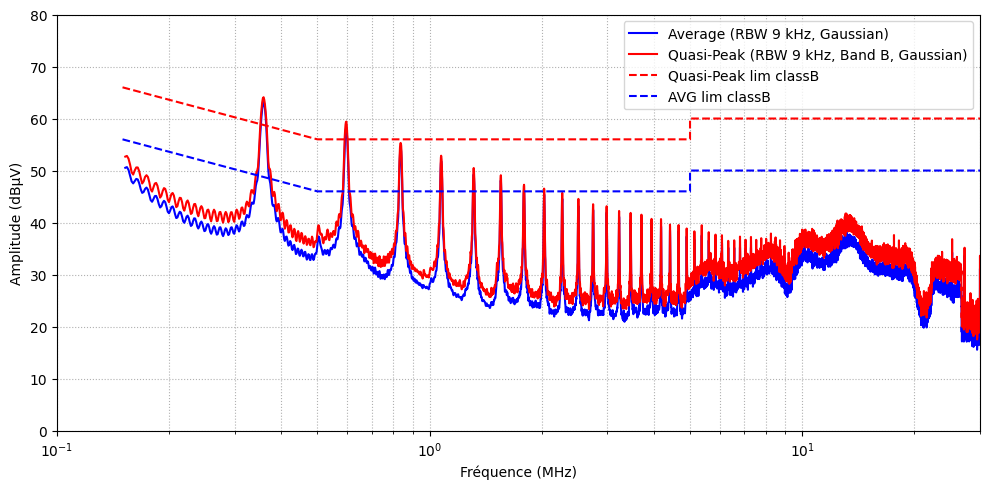

In [459]:
plt.figure(figsize=(10,5))
#plt.semilogx(freqs[1:]*1e-6, dBuV_peak[1:], label='Peak (RBW 9 kHz, Gaussian)')
mask = freqs>=150e3
plt.semilogx(freqs[mask][1:]*1e-6, dBuV_avg[mask][1:],  label='Average (RBW 9 kHz, Gaussian)',c="b")
plt.semilogx(freqs[mask][1:]*1e-6, dBuV_qp[mask][1:],   label='Quasi-Peak (RBW 9 kHz, Band B, Gaussian)',c="r")

# see https://www.ti.com/document-viewer/lit/html/SSZT673
_= """
150 kHz → 530 kHz: 66 dBµV → 56 dBµV (logarithmic slope)
530 kHz → 5 MHz: 56 dBµV (flat)
5 MHz → 30 MHz: 60 dBµV  (flat)
""" # for peak and qpeak is the same , limite are the same for CISPR-16 and 25
# Class A: Limits for industrial/commercial environments → less strict (higher allowed emissions).
# Class B: Limits for residential environments → more strict (lower allowed emissions).
freqs0 = np.array([150e3, 500e3, 5e6, 5e6,30e6])
qp_limits = np.array([66, 56, 56, 60, 60])   # dBµV
avg_limits = np.array([56, 46, 46, 50,50])  # dBµV
plt.semilogx(freqs0*1e-6, qp_limits ,   label='Quasi-Peak lim classB', c="r",linestyle="--")
plt.semilogx(freqs0*1e-6,avg_limits  ,   label='AVG lim classB', c= "b",linestyle="--")
plt.ylim([0,80])
plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (MHz)')
plt.xlim([0.1, 30])
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()

In [464]:
fs = 1e-6*1/Ts
fb= 1/(Ts*10000)

print(f"fs = {fs} Mhz , fb = {fb} Hz")

fs = 100.0 Mhz , fb = 10000.0 Hz


In [467]:
import numpy as np
from scipy.signal import butter, sosfiltfilt

def highpass_butter(arr, fs, fc=80e3, order=4):
    """
    Zero-phase high-pass Butterworth for EMI pre-processing.
    - arr: time series (V)
    - fs : sampling rate (Hz) = 1/Ts
    - fc : cutoff (Hz), pick 80e3..100e3 for Band B work
    - order: 2, 3, or 4 (4 recommended)
    """
    sos = butter(order, fc, btype='highpass', fs=fs, output='sos')
    return sosfiltfilt(sos, arr)

# Example
fs = 1/Ts #= 100e6



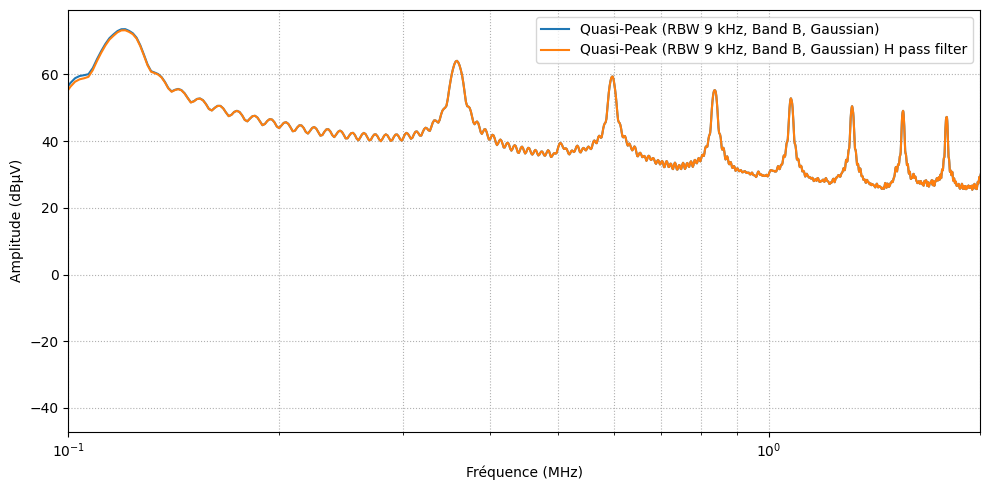

In [469]:
plt.figure(figsize=(10,5))


freqs, dBuV_peak, dBuV_avg, dBuV_qp = emi_detectors_rbw2(
    arr2, Ts, rbw_hz=9e3, window_name='hann', overlap=0.75,
    rbw_shape='gaussian', span_sigmas=5, qp_band='B'
)

plt.semilogx(freqs[1:]*1e-6, dBuV_qp[1:],   label='Quasi-Peak (RBW 9 kHz, Band B, Gaussian)')

arr3 = highpass_butter(arr2, fs=fs, fc=80e3, order=4)

freqs, dBuV_peak, dBuV_avg, dBuV_qp = emi_detectors_rbw2(
    arr3, Ts, rbw_hz=9e3, window_name='hann', overlap=0.75,
    rbw_shape='gaussian', span_sigmas=5, qp_band='B'
)

plt.semilogx(freqs[1:]*1e-6, dBuV_qp[1:],   label='Quasi-Peak (RBW 9 kHz, Band B, Gaussian) H pass filter')

plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (MHz)')
plt.xlim([0.1, 30])
plt.xlim([0.1, 2])
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()

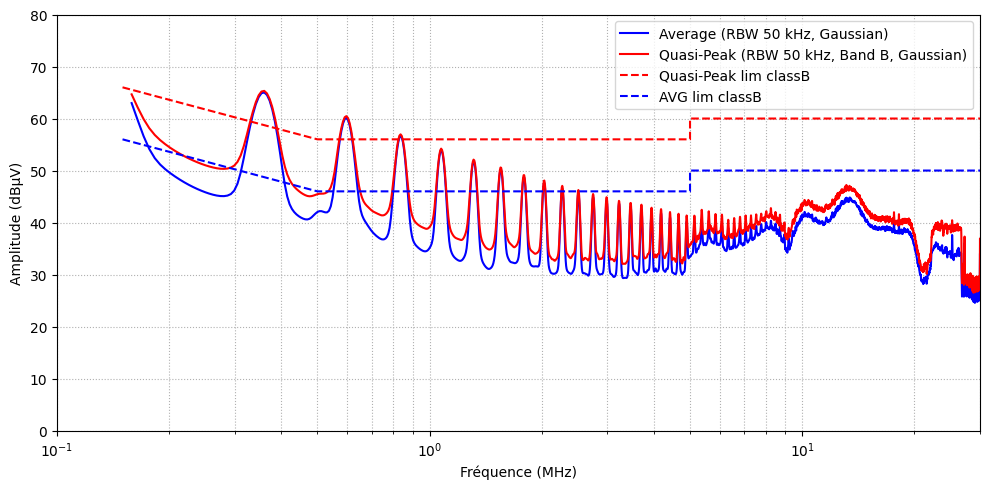

In [471]:
# Just call your function with a larger RBW for diagnostic smoothness
freqs, dBuV_peak, dBuV_avg, dBuV_qp = emi_detectors_rbw2(
    arr2, Ts, rbw_hz=50e3, window_name='hann', overlap=0.75,
    rbw_shape='gaussian', span_sigmas=5, qp_band='B'
)

plt.figure(figsize=(10,5))
#plt.semilogx(freqs[1:]*1e-6, dBuV_peak[1:], label='Peak (RBW 9 kHz, Gaussian)')
mask = freqs>=150e3
plt.semilogx(freqs[mask][1:]*1e-6, dBuV_avg[mask][1:],  label='Average (RBW 50 kHz, Gaussian)',c="b")
plt.semilogx(freqs[mask][1:]*1e-6, dBuV_qp[mask][1:],   label='Quasi-Peak (RBW 50 kHz, Band B, Gaussian)',c="r")

# see https://www.ti.com/document-viewer/lit/html/SSZT673
_= """
150 kHz → 530 kHz: 66 dBµV → 56 dBµV (logarithmic slope)
530 kHz → 5 MHz: 56 dBµV (flat)
5 MHz → 30 MHz: 60 dBµV  (flat)
""" # for peak and qpeak is the same , limite are the same for CISPR-16 and 25
# Class A: Limits for industrial/commercial environments → less strict (higher allowed emissions).
# Class B: Limits for residential environments → more strict (lower allowed emissions).
freqs0 = np.array([150e3, 500e3, 5e6, 5e6,30e6])
qp_limits = np.array([66, 56, 56, 60, 60])   # dBµV
avg_limits = np.array([56, 46, 46, 50,50])  # dBµV
plt.semilogx(freqs0*1e-6, qp_limits ,   label='Quasi-Peak lim classB', c="r",linestyle="--")
plt.semilogx(freqs0*1e-6,avg_limits  ,   label='AVG lim classB', c= "b",linestyle="--")
plt.ylim([0,80])
plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (MHz)')
plt.xlim([0.1, 30])
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()

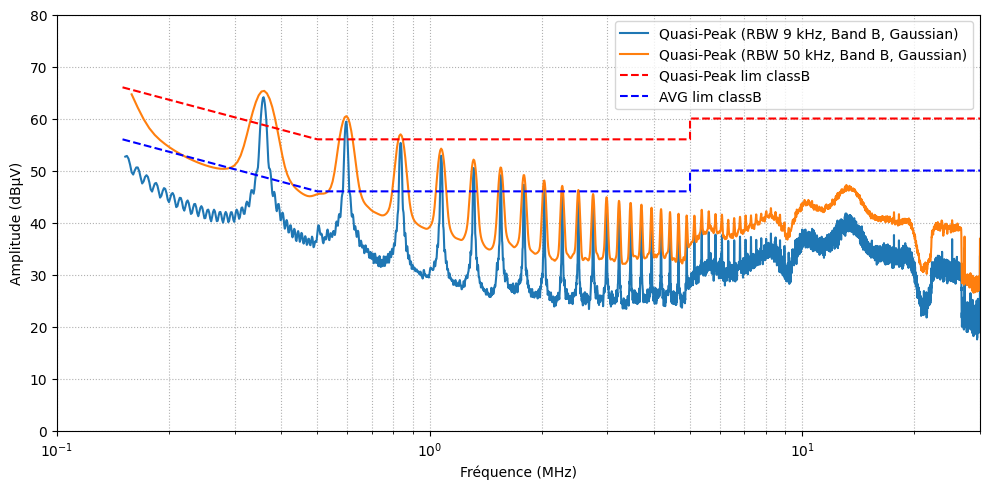

In [473]:
freqs, dBuV_peak, dBuV_avg, dBuV_qp = emi_detectors_rbw2(
    arr2, Ts, rbw_hz=9e3, window_name='hann', overlap=0.75,
    rbw_shape='gaussian', span_sigmas=5, qp_band='B'
)

plt.figure(figsize=(10,5))
#plt.semilogx(freqs[1:]*1e-6, dBuV_peak[1:], label='Peak (RBW 9 kHz, Gaussian)')
mask = freqs>=150e3
#plt.semilogx(freqs[mask][1:]*1e-6, dBuV_avg[mask][1:],  label='Average (RBW 9 kHz, Gaussian)',c="b")
plt.semilogx(freqs[mask][1:]*1e-6, dBuV_qp[mask][1:],   label='Quasi-Peak (RBW 9 kHz, Band B, Gaussian)')

# Just call your function with a larger RBW for diagnostic smoothness
freqs, dBuV_peak, dBuV_avg, dBuV_qp = emi_detectors_rbw2(
    arr2, Ts, rbw_hz=50e3, window_name='hann', overlap=0.75,
    rbw_shape='gaussian', span_sigmas=5, qp_band='B'
)


#plt.semilogx(freqs[1:]*1e-6, dBuV_peak[1:], label='Peak (RBW 9 kHz, Gaussian)')
mask = freqs>=150e3
#plt.semilogx(freqs[mask][1:]*1e-6, dBuV_avg[mask][1:],  label='Average (RBW 50 kHz, Gaussian)',c="b")
plt.semilogx(freqs[mask][1:]*1e-6, dBuV_qp[mask][1:],   label='Quasi-Peak (RBW 50 kHz, Band B, Gaussian)')

# see https://www.ti.com/document-viewer/lit/html/SSZT673
_= """
150 kHz → 530 kHz: 66 dBµV → 56 dBµV (logarithmic slope)
530 kHz → 5 MHz: 56 dBµV (flat)
5 MHz → 30 MHz: 60 dBµV  (flat)
""" # for peak and qpeak is the same , limite are the same for CISPR-16 and 25
# Class A: Limits for industrial/commercial environments → less strict (higher allowed emissions).
# Class B: Limits for residential environments → more strict (lower allowed emissions).
freqs0 = np.array([150e3, 500e3, 5e6, 5e6,30e6])
qp_limits = np.array([66, 56, 56, 60, 60])   # dBµV
avg_limits = np.array([56, 46, 46, 50,50])  # dBµV
plt.semilogx(freqs0*1e-6, qp_limits ,   label='Quasi-Peak lim classB', c="r",linestyle="--")
plt.semilogx(freqs0*1e-6,avg_limits  ,   label='AVG lim classB', c= "b",linestyle="--")
plt.ylim([0,80])
plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (MHz)')
plt.xlim([0.1, 30])
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()


### Preprocessing 

In [479]:
freqs, dBuV_peak, dBuV_avg, dBuV_qp = emi_detectors_rbw2(
    arr2, Ts, rbw_hz=9e3, window_name='hann', overlap=0.75,
    rbw_shape='gaussian', span_sigmas=5, qp_band='B'
)



In [480]:
dBuV_qp

array([65.16488735, 64.95469378, 63.47516062, ..., 27.96584092,
       27.86910994, 27.095287  ], shape=(32769,))

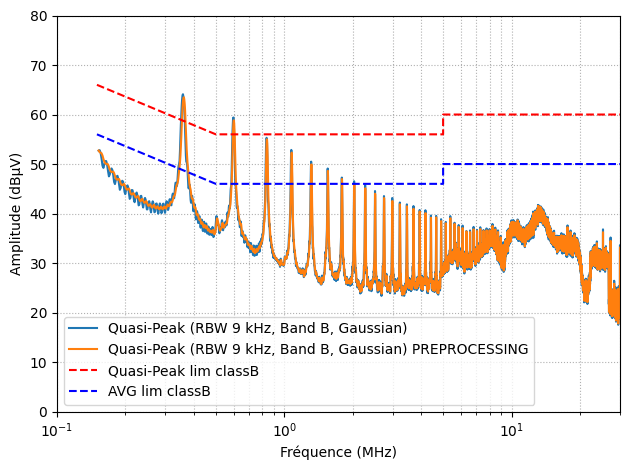

In [485]:



#plt.semilogx(freqs[1:]*1e-6, dBuV_peak[1:], label='Peak (RBW 9 kHz, Gaussian)')
mask = freqs>=150e3
#plt.semilogx(freqs[mask][1:]*1e-6, dBuV_avg[mask][1:],  label='Average (RBW 50 kHz, Gaussian)',c="b")
plt.semilogx(freqs[mask][1:]*1e-6, dBuV_qp[mask][1:],   label='Quasi-Peak (RBW 9 kHz, Band B, Gaussian)')
dBuV_qp2= pd.Series(dBuV_qp).rolling(window=5).mean()
plt.semilogx(freqs[mask][1:]*1e-6, dBuV_qp2[mask][1:],   label='Quasi-Peak (RBW 9 kHz, Band B, Gaussian) PREPROCESSING')

dBuV_qp3= pd.Series(dBuV_qp).rolling(window=10).max()
#plt.semilogx(freqs[mask][1:]*1e-6, dBuV_qp3[mask][1:],   label='Quasi-Peak (RBW 9 kHz, Band B, Gaussian) PREPROCESSING')

# see https://www.ti.com/document-viewer/lit/html/SSZT673
_= """
150 kHz → 530 kHz: 66 dBµV → 56 dBµV (logarithmic slope)
530 kHz → 5 MHz: 56 dBµV (flat)
5 MHz → 30 MHz: 60 dBµV  (flat)
""" # for peak and qpeak is the same , limite are the same for CISPR-16 and 25
# Class A: Limits for industrial/commercial environments → less strict (higher allowed emissions).
# Class B: Limits for residential environments → more strict (lower allowed emissions).
freqs0 = np.array([150e3, 500e3, 5e6, 5e6,30e6])
qp_limits = np.array([66, 56, 56, 60, 60])   # dBµV
avg_limits = np.array([56, 46, 46, 50,50])  # dBµV
plt.semilogx(freqs0*1e-6, qp_limits ,   label='Quasi-Peak lim classB', c="r",linestyle="--")
plt.semilogx(freqs0*1e-6,avg_limits  ,   label='AVG lim classB', c= "b",linestyle="--")
plt.ylim([0,80])
plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (MHz)')
plt.xlim([0.1, 30])
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()

In [495]:
np.diff(freqs )[0]

np.float64(1525.87890625)

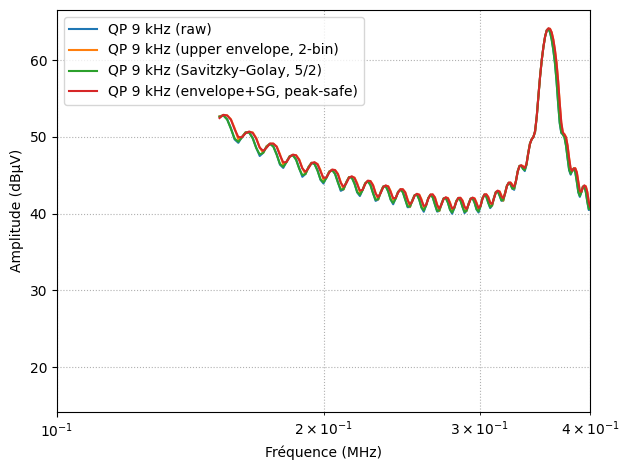

In [492]:
import numpy as np
from scipy.ndimage import maximum_filter1d

# dBuV_qp is your quasi-peak array
# Use a window just big enough to swallow the 10 kHz stair-step: 2 bins
dBuV_qp_env = maximum_filter1d(dBuV_qp, size=2, mode='nearest')

mask = freqs >= 150e3
plt.semilogx(freqs[mask][1:]*1e-6, dBuV_qp[mask][1:], label='QP 9 kHz (raw)')
plt.semilogx(freqs[mask][1:]*1e-6, dBuV_qp_env[mask][1:], label='QP 9 kHz (upper envelope, 2-bin)')




from scipy.signal import savgol_filter

# window length must be odd; keep it small (3 or 5) to avoid peak loss
dBuV_qp_sg = savgol_filter(dBuV_qp, window_length=5, polyorder=2, mode='mirror')
plt.semilogx(freqs[mask][1:]*1e-6, dBuV_qp_sg[mask][1:], label='QP 9 kHz (Savitzky–Golay, 5/2)')






def parabolic_peak(f, y):
    # Given index of max k, fit parabola through (k-1,k,k+1)
    k = np.argmax(y)
    if k == 0 or k == len(y)-1:
        return f[k], y[k]
    y0, y1, y2 = y[k-1], y[k], y[k+1]
    denom = 2*(y0 - 2*y1 + y2)
    delta = 0 if denom == 0 else (y0 - y2)/denom
    fpk = f[k] + delta*(f[k+1]-f[k])  # assumes quasi-uniform bins locally
    ypk = y1 - 0.25*(y0 - y2)*delta
    return fpk, ypk
from scipy.ndimage import maximum_filter1d
from scipy.signal import savgol_filter

dBuV_qp_env = maximum_filter1d(dBuV_qp, size=2, mode='nearest')
dBuV_qp_pretty = savgol_filter(dBuV_qp_env, window_length=5, polyorder=2, mode='mirror')

#plt.semilogx(freqs[mask][1:]*1e-6, dBuV_qp[mask][1:],         label='QP 9 kHz raw')
plt.semilogx(freqs[mask][1:]*1e-6, dBuV_qp_pretty[mask][1:],  label='QP 9 kHz (envelope+SG, peak-safe)')




plt.xlim([0.1,0.4])


plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (MHz)')

plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()

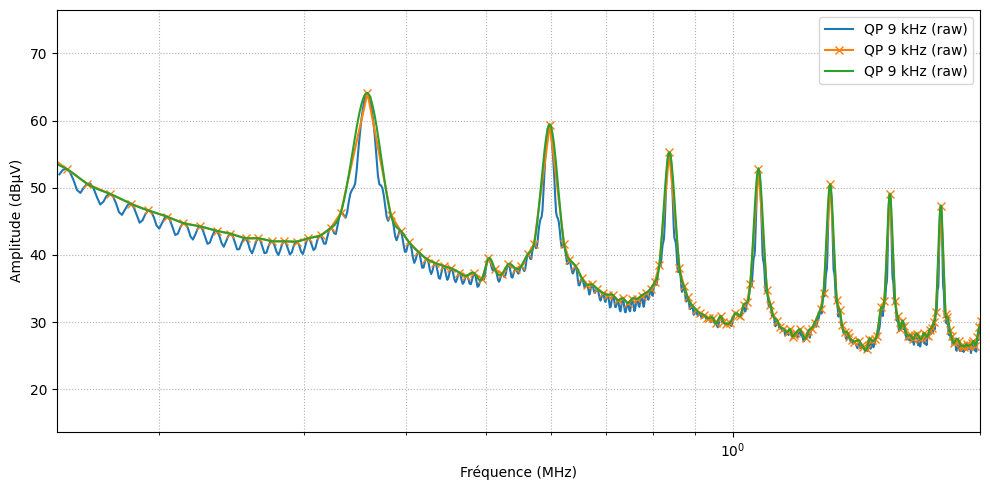

In [510]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

find_peaks(dBuV_qp, distance=5)
# Plot
mask = freqs >= 150e3
plt.figure(figsize=(10,5))
plt.semilogx(freqs[mask]*1e-6, dBuV_qp[mask],      label='QP 9 kHz (raw)')
peaks, _= find_peaks(dBuV_qp, distance=2)
dbpeak = dBuV_qp[peaks]
freqpeak= freqs[peaks]
plt.semilogx(freqpeak*1e-6,dbpeak ,      label='QP 9 kHz (raw)', marker="x")


env_fun = interp1d(freqpeak, dbpeak , kind='cubic', bounds_error=False, fill_value="extrapolate")
dbpeakinter = env_fun(freqs)

plt.semilogx(freqs*1e-6,dbpeakinter ,      label='QP 9 kHz (raw)')

plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (MHz)')
plt.ylabel('Amplitude (dBµV)')
plt.xlim([0.15, 2.0])  # or [0.15, 30]
plt.legend()
plt.tight_layout()
plt.show()


In [525]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

# max step = 5khz see 
# RBW of 9 kHz and a maximum step size of 5 kHz 
# https://www.ti.com/lit/eb/slyy208/slyy208.pdf
def remove_oscillation_10kHz(freqs , dBuV_qp, step = 2.5e3):
    
    find_peaks(dBuV_qp, distance=5)
    peaks, _= find_peaks(dBuV_qp, distance=2)
    dbpeak = dBuV_qp[peaks]
    freqpeak= freqs[peaks]
    newFreq= np.arange(150e3,30e6,step)
    env_fun = interp1d(freqpeak, dbpeak , kind='cubic', bounds_error=False, fill_value="extrapolate")
    dbpeakinter = env_fun(newFreq)
    return newFreq, dbpeakinter

In [533]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

# max step = 5khz see 
# RBW of 9 kHz and a maximum step size of 5 kHz 
# https://www.ti.com/lit/eb/slyy208/slyy208.pdf
def remove_oscillation_10kHz(freqs , dBuV_qp, step = 2.5e3,fstart=150e3, fend=30e6, distance=2):
    """
    Removes small oscillations (~10 kHz) from quasi-peak spectrum data
    by extracting the peak envelope and interpolating it with a smooth curve.

    Parameters
    ----------
    freqs : ndarray
        Frequency array in Hz corresponding to the measurements.
    dBuV_qp : ndarray
        Quasi-peak detector amplitude values in dBµV.
    step : float, optional
        Frequency step in Hz for interpolation (default = 2.5 kHz).

    Returns
    -------
    newFreq : ndarray
        New frequency grid from 150 kHz to 30 MHz with given step.
    dbpeakinter : ndarray
        Interpolated envelope values (dBµV) corresponding to newFreq.
    """

    # Detect peaks with a tighter distance (actual peaks used in envelope construction)
    peaks, _ = find_peaks(dBuV_qp, distance=distance)

    # Extract amplitude values of detected peaks
    dbpeak = dBuV_qp[peaks]

    # Extract frequency positions of detected peaks
    freqpeak = freqs[peaks]

    # Define new frequency grid from 150 kHz to 30 MHz
    newFreq = np.arange(fstart, fend, step)

    # Interpolate envelope over the new frequency grid using cubic interpolation
    env_fun = interp1d(
        freqpeak, dbpeak, 
        kind='cubic', 
        bounds_error=False, 
        fill_value="extrapolate"
    )

    # Evaluate the interpolated envelope
    dbpeakinter = env_fun(newFreq)

    return newFreq, dbpeakinter


In [534]:
newFreq

array([  150000.,   152500.,   155000., ..., 29992500., 29995000.,
       29997500.], shape=(11940,))

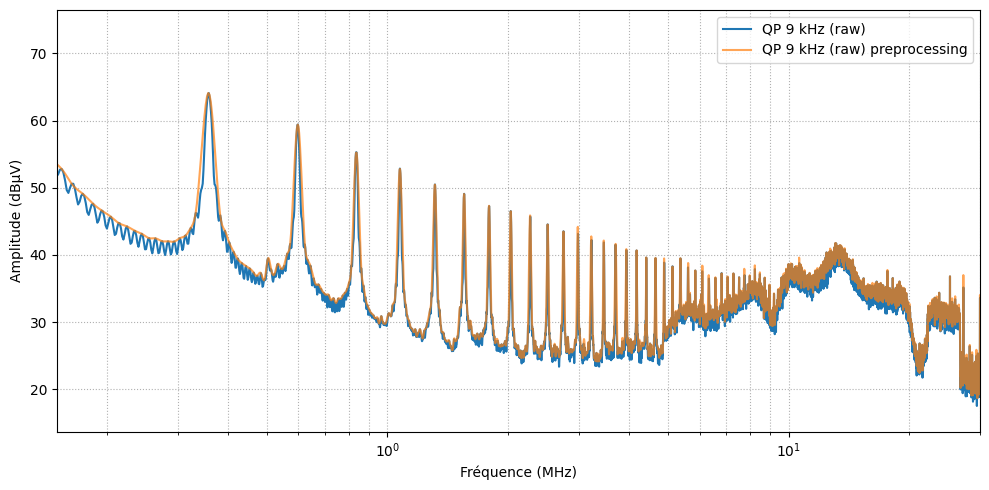

In [535]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d


plt.figure(figsize=(10,5))
plt.semilogx(freqs*1e-6, dBuV_qp,      label='QP 9 kHz (raw)')

newFreq, dbpeakinter= remove_oscillation_10kHz(freqs , dBuV_qp)
plt.semilogx(newFreq*1e-6, dbpeakinter,      label='QP 9 kHz (raw) preprocessing',alpha=0.7)

plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (MHz)')
plt.ylabel('Amplitude (dBµV)')
plt.xlim([0.15, 30])  # or [0.15, 30]
plt.legend()
plt.tight_layout()
plt.show()


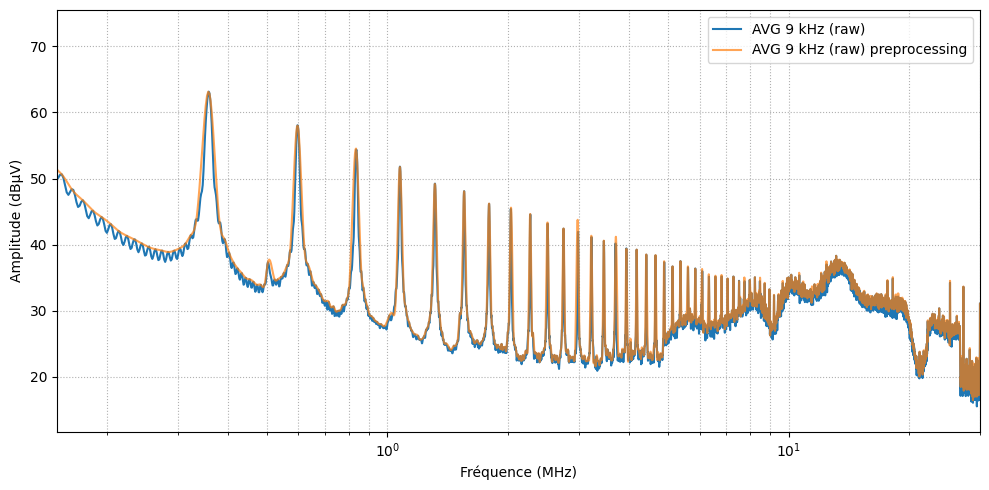

In [536]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d


plt.figure(figsize=(10,5))
plt.semilogx(freqs*1e-6, dBuV_avg,      label='AVG 9 kHz (raw)')

newFreq, dbavginter= remove_oscillation_10kHz(freqs , dBuV_avg)
plt.semilogx(newFreq*1e-6, dbavginter,      label='AVG 9 kHz (raw) preprocessing',alpha=0.7)

plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (MHz)')
plt.ylabel('Amplitude (dBµV)')
plt.xlim([0.15, 30])  # or [0.15, 30]
plt.legend()
plt.tight_layout()
plt.show()


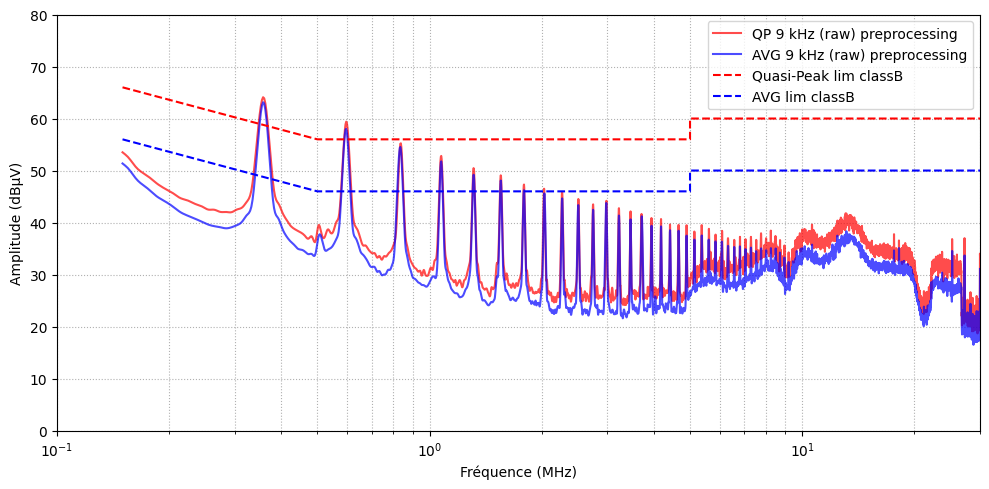

In [537]:
plt.figure(figsize=(10,5))

plt.semilogx(newFreq*1e-6, dbpeakinter,      label='QP 9 kHz (raw) preprocessing',alpha=0.7,c='r')
plt.semilogx(newFreq*1e-6, dbavginter,      label='AVG 9 kHz (raw) preprocessing',alpha=0.7,c='b')


# see https://www.ti.com/document-viewer/lit/html/SSZT673
_= """
150 kHz → 530 kHz: 66 dBµV → 56 dBµV (logarithmic slope)
530 kHz → 5 MHz: 56 dBµV (flat)
5 MHz → 30 MHz: 60 dBµV  (flat)
""" # for peak and qpeak is the same , limite are the same for CISPR-16 and 25
# Class A: Limits for industrial/commercial environments → less strict (higher allowed emissions).
# Class B: Limits for residential environments → more strict (lower allowed emissions).
freqs0 = np.array([150e3, 500e3, 5e6, 5e6,30e6])
qp_limits = np.array([66, 56, 56, 60, 60])   # dBµV
avg_limits = np.array([56, 46, 46, 50,50])  # dBµV
plt.semilogx(freqs0*1e-6, qp_limits ,   label='Quasi-Peak lim classB', c="r",linestyle="--")
plt.semilogx(freqs0*1e-6,avg_limits  ,   label='AVG lim classB', c= "b",linestyle="--")
plt.ylim([0,80])
plt.grid(True, which='both', ls=':')
plt.xlabel('Fréquence (MHz)')
plt.xlim([0.1, 30])
plt.ylabel('Amplitude (dBµV)')
plt.legend()
plt.tight_layout()
plt.show()